/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_58919/3461858074.py:209: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unadjS = stock.history(period="1d")['Close'][-1]  # Get the most recent close price (unadjusted)
[*********************100%***********************]  1 of 1 completed
/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_58919/3461858074.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = data['Adj Close'][-1]  # Latest stock price (adjusted for dividends and splits)


Adjusted current stock price = 191.80 while the unadjusted value = 228.20.
saeed 7 0.019178082191780823 0.0027397260273972603


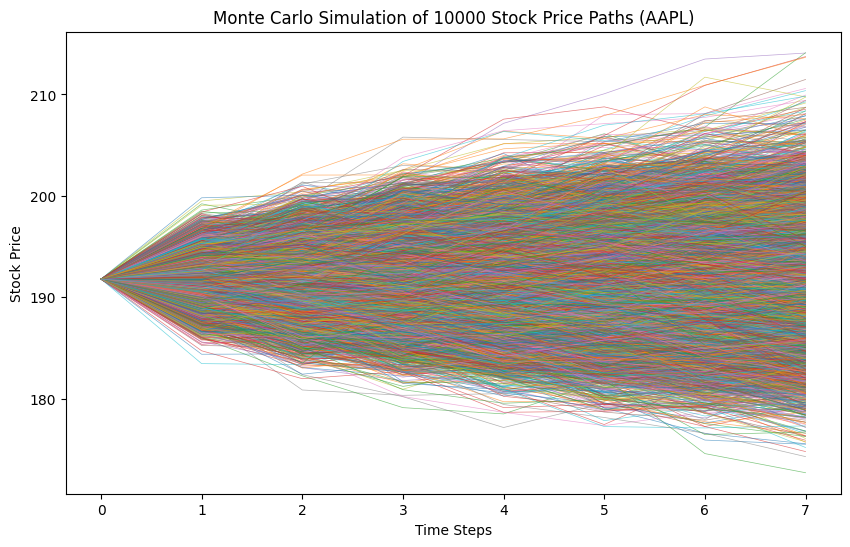

Sigma: 0.0000, Calculated Price: 15.4990, Market Price: 22.2500, Price Diff: -6.7510
Sigma: 10.0000, Calculated Price: 109.9225, Market Price: 22.2500, Price Diff: 87.6725
Sigma: 0.7150, Calculated Price: 17.9346, Market Price: 22.2500, Price Diff: -4.3154
Sigma: 1.9223, Calculated Price: 29.7678, Market Price: 22.2500, Price Diff: 7.5178
Sigma: 1.1553, Calculated Price: 21.9403, Market Price: 22.2500, Price Diff: -0.3097
Sigma: 1.1880, Calculated Price: 22.2604, Market Price: 22.2500, Price Diff: 0.0104
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: 0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Report saved to options_report.txt


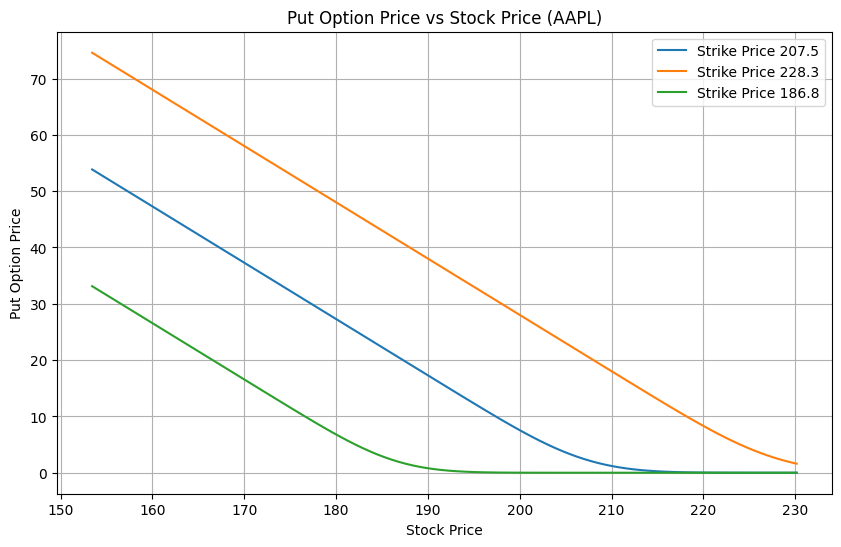

In [54]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import os

option_type = 'put'
OUTPUT_FOLDER = "output"

def black_scholes_option(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

# Binomial Tree Model
def binomial_tree_option_price(S, K, T, r, sigma, N):
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))  # up factor
    d = 1 / u  # down factor
    p = (np.exp(r * dt) - d) / (u - d)  # risk-neutral probability

    # Initialize asset prices at maturity
    ST = np.zeros(N + 1)
    for i in range(N + 1):
        ST[i] = S * (u ** (N - i)) * (d ** i)

    # Initialize option values at maturity
    if option_type == 'call':
        option_values = np.maximum(0, ST - K)
    else:
        option_values = np.maximum(0, K - ST)

    # Backward induction
    for j in range(N - 1, -1, -1):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

# Monte Carlo Simulation
def monte_carlo_option_price(S, K, T, r, sigma, num_simulations=10000):
    
    dt = 1 / 365  # Daily steps
    num_steps = int(T * 365)  # Number of days until maturity
    print('saeed',num_steps,T,dt)
    payoffs = [] # This list will store the payoff from each simulation, which will later be averaged to determine the option price.
    paths = []  # To store all paths
    for _ in range(num_simulations):
        ST = S
        path = [S]  # Store each path (starting with initial stock price)

        for _ in range(num_steps): # step through the stock price over time increments (dt)
            Z = np.random.normal() # Generate a random standard normal variable

            # Geometric Brownian Motion
                #The stock price evolves according to geometric Brownian motion. This means the price has both a deterministic drift (due to the risk-free rate) and a random component (due to volatility)
                    # This formula consists of two parts:
                        # Drift: (r - 0.5 * sigma^2) * dt which reflects the deterministic growth of the stock price.
                        # Volatility: sigma * sqrt(dt) * Z, which reflects randomness in price fluctuations.
            ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z) # The new stock price ST is updated based on the formula for geometric Brownian motion:
            path.append(ST)  # Store each step of the path
        paths.append(path)  # Append the full path
        if option_type == 'call':
            payoffs.append(max(0, ST - K))
        else:
            payoffs.append(max(0, K - ST))


    # Discount Factor: np.exp(-r * T): The payoffs are discounted to present value using exp(-r * T), which accounts for the time value of money, ensuring that future payoffs are valued at today's price.
    # Average Payoff: np.mean(payoffs) : Calculate the mean of all the simulated payoffs 
    # Return the Option Price: The final option price is the discounted average payoff.


    # Plot all paths
    plt.figure(figsize=(10, 6))
    for path in paths:
        plt.plot(path, linewidth=0.5, alpha=0.6)
    
    plt.title(f'Monte Carlo Simulation of {num_simulations} Stock Price Paths ({ticker})')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plot_path = os.path.join(OUTPUT_FOLDER, 'Monte Carlo Simulations.png')
    plt.savefig(plot_path)
    plt.show()
    return np.exp(-r * T) * np.mean(payoffs) 

# General Greeks function
def greeks(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        delta = norm.cdf(d1)
        theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) -
                  r * K * np.exp(-r * T) * norm.cdf(d2))
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    else:
        delta = norm.cdf(d1) - 1
        theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) +
                  r * K * np.exp(-r * T) * norm.cdf(-d2))
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

    return delta, gamma, vega, theta, rho

# Function to calculate implied volatility
def implied_volatility(S, K, T, r, market_price):
    def option_price_diff(sigma):
        price = black_scholes_option(S, K, T, r, sigma, q=0)
        price_diff = price - market_price
        print(f"Sigma: {sigma:.4f}, Calculated Price: {price:.4f}, Market Price: {market_price:.4f}, Price Diff: {price_diff:.4f}")
        return price_diff

    return brentq(option_price_diff, 1e-6, 10)  # Solve for sigma

# Fetch stock data from Yahoo Finance
def get_stock_data(ticker):
    try:
        data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
        if data.empty:
            raise ValueError("No data found for the given ticker.")
        return data
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None

# Calculate historical volatility (annualized)
def calculate_volatility(data):
    data['Returns'] = data['Adj Close'].pct_change()  # Calculate daily returns
    historical_volatility = data['Returns'].std() * np.sqrt(252)  # Annualized volatility
    return historical_volatility

# Function to plot option price vs stock price
def plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma):
    plt.figure(figsize=(10, 6))
    for K in K_list:
        option_prices = [black_scholes_option(S, K, T, r, sigma, q=0) for S in S_range]
        plt.plot(S_range, option_prices, label=f"Strike Price {K:.1f}")

    plt.title(f"{option_type.capitalize()} Option Price vs Stock Price ({ticker})")
    plt.xlabel("Stock Price")
    plt.ylabel(f"{option_type.capitalize()} Option Price")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(OUTPUT_FOLDER, 'Option_price_vs_stock_price.png')
    plt.savefig(plot_path)
    plt.show()

# Function to generate report
def generate_report(ticker, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price):
    os.makedirs("output", exist_ok=True)

    report = f"""
    Options Pricing and Greeks Calculation Report

    1. User Inputs:
    - Stock Ticker: {ticker}
    - Stock Price (S): {S:.1f}
    - Strike Price (K): {K}
    - Days to Expiration: {int(T * 365)} days
    - Risk-Free Rate (r): {r * 100:.2f}%
    - Market Price of the Option: {market_price}

    2. Calculated Intermediate Values:
    - Time to Maturity (T): {T:.4f} years
    - Historical Volatility (σ): {sigma * 100:.2f}%

    3. Option Prices:
    - Option Price (Black-Scholes): {bs_price:.2f}
    - Option Price (Monte Carlo): {mc_price:.2f}
    - Option Price (Binomial Tree): {bt_price:.2f}

    4. Greeks:
    - Delta: {delta:.4f}
    - Gamma: {gamma_val:.4f}
    - Vega: {vega_val:.4f}
    - Theta: {theta_val:.4f}
    - Rho: {rho_val:.4f}

    5. Implied Volatility Calculation:
    - Implied Volatility (IV): {iv * 100:.2f}%
    """
    
    report_path = os.path.join(OUTPUT_FOLDER, "options_report.txt")
    with open(report_path, "w") as file:
        file.write(report)

    print("Report saved to options_report.txt")


# Main code
if __name__ == "__main__":
    ticker = 'AAPL'
    K = 207.5
    days_to_maturity = 7
    T = days_to_maturity / 365
    r = 0.05  # Risk-free rate (5%)
    stock = yf.Ticker(ticker)
    unadjS = stock.history(period="1d")['Close'][-1]  # Get the most recent close price (unadjusted)

    # Fetch stock data
    data = get_stock_data(ticker)
    if data is not None:
        S = data['Adj Close'][-1]  # Latest stock price (adjusted for dividends and splits)

        print(f'Adjusted current stock price = {S:.2f} while the unadjusted value = {unadjS:.2f}.')
        sigma = calculate_volatility(data)  # Historical volatility

        # Calculate option prices
        bs_price = black_scholes_option(S, K, T, r, sigma, q=0)
        mc_price = monte_carlo_option_price(S, K, T, r, sigma)
        bt_price = binomial_tree_option_price(S, K, T, r, sigma, N=100)

        # Calculate Greeks for call option
        delta, gamma_val, vega_val, theta_val, rho_val = greeks(S, K, T, r, sigma)

        # Implied volatility calculation
        market_price = 22.25
        iv = implied_volatility(S, K, T, r, market_price)

        # Generate and save report
        generate_report(ticker, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price)

        # Plot call and put option price vs stock price
        S_range = np.linspace(S * 0.8, S * 1.2, 100)  # Stock price range for plot
        K_list = [K, K * 1.1, K * 0.9]  # Different strike prices for comparison

        plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma)
